In [35]:
import sys
import os
sys.path.append('C:\\Users\\luoyan011\\Desktop\\PersonalLearning\\GitHub\\python_functions\\jl_nlp_pkg')
sys.path.append('C:\\Users\\luoyan011\\Desktop\\PersonalLearning\\GitHub\\python_functions\\jl_model_explain_pkg')
import nlpbasic.textClean as textClean
import nlpbasic.docVectors as DocVector
import nlpbasic.dataExploration as DataExploration
import nlpbasic.lda as lda
import nlpbasic.tfidf as tfidf

import model_explain.plot as meplot
import model_explain.shap as meshap
import data_visualization.distribution_plot as dbplot

from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from numpy import array,asarray,zeros
from scipy.spatial import distance
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense,Flatten,Embedding
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np
import re
from nltk.tokenize import word_tokenize
pd.set_option('display.max_colwidth', None)
root_path = 'C:\\Users\\luoyan011\\Desktop\\PersonalLearning\\GitHub\\NLP_data\\research_article_category'

In [2]:
def generate_target(data):
    tmp = data.copy()
    tmp.set_index(['ID','TITLE','ABSTRACT'],inplace=True)
    tmp['LABEL'] = tmp.idxmax(axis=1)
    tmp = tmp.reset_index()
    tmp = tmp[['ID','TITLE','ABSTRACT','LABEL']]
    return tmp 


In [3]:
train = pd.read_csv(os.path.join(root_path, "train.csv"))
test = pd.read_csv(os.path.join(root_path, "test.csv"))
train = generate_target(train)
train.head(3) 

,ID,TITLE,ABSTRACT,LABEL
0,1,Reconstructing Subject-Specific Effect Maps,"Predictive models allow subject-specific inference when analyzing disease\nrelated alterations in neuroimaging data. Given a subject's data, inference can\nbe made at two levels: global, i.e. identifiying condition presence for the\nsubject, and local, i.e. detecting condition effect on each individual\nmeasurement extracted from the subject's data. While global inference is widely\nused, local inference, which can be used to form subject-specific effect maps,\nis rarely used because existing models often yield noisy detections composed of\ndispersed isolated islands. In this article, we propose a reconstruction\nmethod, named RSM, to improve subject-specific detections of predictive\nmodeling approaches and in particular, binary classifiers. RSM specifically\naims to reduce noise due to sampling error associated with using a finite\nsample of examples to train classifiers. The proposed method is a wrapper-type\nalgorithm that can be used with different binary classifiers in a diagnostic\nmanner, i.e. without information on condition presence. Reconstruction is posed\nas a Maximum-A-Posteriori problem with a prior model whose parameters are\nestimated from training data in a classifier-specific fashion. Experimental\nevaluation is performed on synthetically generated data and data from the\nAlzheimer's Disease Neuroimaging Initiative (ADNI) database. Results on\nsynthetic data demonstrate that using RSM yields higher detection accuracy\ncompared to using models directly or with bootstrap averaging. Analyses on the\nADNI dataset show that RSM can also improve correlation between\nsubject-specific detections in cortical thickness data and non-imaging markers\nof Alzheimer's Disease (AD), such as the Mini Mental State Examination Score\nand Cerebrospinal Fluid amyloid-$\beta$ levels. Further reliability studies on\nthe longitudinal ADNI dataset show improvement on detection reliability when\nRSM is used.\n",Computer Science
1,2,Rotation Invariance Neural Network,"Rotation invariance and translation invariance have great values in image\nrecognition tasks. In this paper, we bring a new architecture in convolutional\nneural network (CNN) named cyclic convolutional layer to achieve rotation\ninvariance in 2-D symbol recognition. We can also get the position and\norientation of the 2-D symbol by the network to achieve detection purpose for\nmultiple non-overlap target. Last but not least, this architecture can achieve\none-shot learning in some cases using those invariance.\n",Computer Science
2,3,Spherical polyharmonics and Poisson kernels for polyharmonic functions,"We introduce and develop the notion of spherical polyharmonics, which are a\nnatural generalisation of spherical harmonics. In particular we study the\ntheory of zonal polyharmonics, which allows us, analogously to zonal harmonics,\nto construct Poisson kernels for polyharmonic functions on the union of rotated\nballs. We find the representation of Poisson kernels and zonal polyharmonics in\nterms of the Gegenbauer polynomials. We show the connection between the\nclassical Poisson kernel for harmonic functions on the ball, Poisson kernels\nfor polyharmonic functions on the union of rotated balls, and the Cauchy-Hua\nkernel for holomorphic functions on the Lie ball.\n",Mathematics


Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


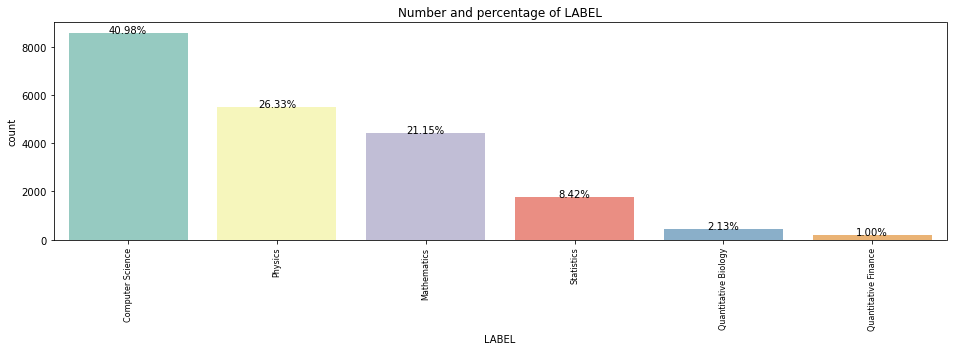

In [4]:
dbplot.plot_count_dist("LABEL", "LABEL", train, 4, True)

In [6]:
tagged_data = [TaggedDocument(words=word_tokenize(_d.lower()), tags=[str(i)]) for i, _d in enumerate(train['TITLE'].to_list())]
max_epochs = 100
vec_size = 20
alpha = 0.025

model = Doc2Vec(size=vec_size,
                alpha=alpha, 
                min_alpha=0.00025,
                min_count=1,
                dm =1)
  
model.build_vocab(tagged_data)

for epoch in range(max_epochs):
    print('iteration {0}'.format(epoch))
    model.train(tagged_data,
                total_examples=model.corpus_count,
                epochs=model.iter)
    # decrease the learning rate
    model.alpha -= 0.0002
    # fix the learning rate, no decay
    model.min_alpha = model.alpha
model.save(os.path.join(root_path, "d2v.model"))

The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.


iteration 0


Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
iteration 11
iteration 12
iteration 13
iteration 14
iteration 15
iteration 16
iteration 17
iteration 18
iteration 19
iteration 20
iteration 21
iteration 22
iteration 23
iteration 24
iteration 25
iteration 26
iteration 27
iteration 28
iteration 29
iteration 30
iteration 31
iteration 32
iteration 33
iteration 34
iteration 35
iteration 36
iteration 37
iteration 38
iteration 39
iteration 40
iteration 41
iteration 42
iteration 43
iteration 44
iteration 45
iteration 46
iteration 47
iteration 48
iteration 49
iteration 50
iteration 51
iteration 52
iteration 53
iteration 54
iteration 55
iteration 56
iteration 57
iteration 58
iteration 59
iteration 60
iteration 61
iteration 62
iteration 63
iteration 64
iteration 65
iteration 66
iteration 67
iteration 68
iteration 69
iteration 70
iteration 71
iteration 72
iteration 73
iteration 74
iteration 75
iteration 76
iteration 77
iteratio

In [22]:
df_train, df_test = train_test_split(train, test_size=0.3, random_state=42)
model= Doc2Vec.load(os.path.join(root_path, "d2v.model"))
train_tag = df_train.apply(lambda r: TaggedDocument(words=word_tokenize(r['TITLE']), tags=[r.LABEL]), axis=1)
test_tag = df_test.apply(lambda r: TaggedDocument(words=word_tokenize(r['TITLE']), tags=[r.LABEL]), axis=1)

In [23]:
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in tagged_docs])
    return targets, regressors

In [27]:
y_train, X_train = vec_for_learning(model, train_tag)
y_test, X_test = vec_for_learning(model, test_tag)

In [30]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(n_jobs=1, C=1e5)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [32]:
confusion_matrix(y_test, y_pred)

array([[2113,  119,  301,    0,    0,    2],
       [ 656,  368,  298,    0,    0,    2],
       [ 840,  238,  631,    0,    0,    1],
       [  73,   20,   49,    0,    0,    1],
       [  40,    5,   15,    0,    0,    0],
       [ 407,   37,   73,    0,    0,    3]], dtype=int64)

In [34]:
print(classification_report(y_test, y_pred))

                      precision    recall  f1-score   support

    Computer Science       0.51      0.83      0.63      2535
         Mathematics       0.47      0.28      0.35      1324
             Physics       0.46      0.37      0.41      1710
Quantitative Biology       0.00      0.00      0.00       143
Quantitative Finance       0.00      0.00      0.00        60
          Statistics       0.33      0.01      0.01       520

            accuracy                           0.50      6292
           macro avg       0.30      0.25      0.23      6292
        weighted avg       0.46      0.50      0.44      6292



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
